In [1]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00


In [2]:
pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 13.9 MB/s eta 0:00:00


In [3]:
pip install lightgbm

In [4]:
pip install catboost

In [5]:
pip install xgboost

In [1]:
import random
from sklearn.metrics import r2_score, mean_absolute_error,mean_absolute_percentage_error
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import  train_test_split
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
import numpy as np

In [2]:
df = pd.read_csv('‘Adenosine_receptor_a2a_human.tsv', sep='\t')

In [3]:
mask = (df['Ki (nM)'].notna()) | (df['IC50 (nM)'].notna())
df = df.loc[mask, :]

In [4]:
df = df[df['Target Source Organism According to Curator or DataSource'] == 'Homo sapiens']
df.shape

(10924, 52)

In [5]:
columns_to_choose = ['Ligand SMILES', 'Ligand InChI', 'BindingDB Ligand Name', 'Target Name', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)']

In [6]:
df_processed = df[columns_to_choose]

In [7]:
df['IC50 (nM)'] = df['IC50 (nM)'].combine_first(df['Ki (nM)'])

In [8]:
df = df.drop(['Ki (nM)'], axis=1)

In [9]:
def convert_ki_value(x):
    if pd.isna(x):
        return np.nan
    if x.startswith('>'):
        return float(x[1:])
    elif x.startswith('<'):
        return float(x[1:])
    else:
        return float(x)

df['IC50 (nM)'] = df['IC50 (nM)'].apply(convert_ki_value)

In [10]:
df['pKi'] = -np.log10(df['IC50 (nM)'] * 1e-9)


df.loc[df['IC50 (nM)'] == '>100000', 'pKi'] = 4.0
df.loc[df['IC50 (nM)'] == '<10', 'pKi'] = 8.0

In [11]:
df

,BindingDB Reactant_set_id,Ligand SMILES,Ligand InChI,Ligand InChI Key,BindingDB MonomerID,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,IC50 (nM),Kd (nM),...,UniProt (SwissProt) Entry Name of Target Chain,UniProt (SwissProt) Primary ID of Target Chain,UniProt (SwissProt) Secondary ID(s) of Target Chain,UniProt (SwissProt) Alternative ID(s) of Target Chain,UniProt (TrEMBL) Submitted Name of Target Chain,UniProt (TrEMBL) Entry Name of Target Chain,UniProt (TrEMBL) Primary ID of Target Chain,UniProt (TrEMBL) Secondary ID(s) of Target Chain,UniProt (TrEMBL) Alternative ID(s) of Target Chain,pKi
100,50722663,COc1cnc(N2CCOCC2)c2sc(NC(=O)C(C)(C)Oc3cccc(F)c...,"InChI=1S/C21H23FN4O4S/c1-21(2,30-14-6-4-5-13(2...",XSDASQOPCIPRKT-UHFFFAOYSA-N,50235049,CHEMBL4097118,Adenosine receptor A2a,Homo sapiens,4.70,NaN,...,AA2AR_HUMAN,P29274,B2R7E0,NaN,NaN,NaN,NaN,NaN,NaN,8.327902
102,50849570,Nc1nc2ccc(Cl)cc2n2n1nc(-c1ccccc1)c2=O,InChI=1S/C15H10ClN5O/c16-10-6-7-11-12(8-10)20-...,LEOMMCGIZNQEEE-UHFFFAOYSA-N,50224350,"4-amino-8-chloro-2-phenyl-3,3a,5,9b-tetraaza-c...",Adenosine receptor A2a,Homo sapiens,4.70,NaN,...,AA2AR_HUMAN,P29274,B2R7E0,NaN,NaN,NaN,NaN,NaN,NaN,8.327902
103,50573690,CN(C)CCN(C)c1ccc2C(=O)c3c(nc(N)nc3-c3ccccc3)-c2c1,InChI=1S/C22H23N5O/c1-26(2)11-12-27(3)15-9-10-...,WUIPOKWUCKPSLZ-UHFFFAOYSA-N,50316891,2-amino-8-((2-(dimethylamino)ethyl)(methyl)ami...,Adenosine receptor A2a,Homo sapiens,4.70,NaN,...,AA2AR_HUMAN,P29274,B2R7E0,NaN,NaN,NaN,NaN,NaN,NaN,8.327902
104,50833950,Cn1c(nc2c(N)nc(CCc3ccccc3)nc12)-n1nccn1,InChI=1S/C16H16N8/c1-23-15-13(22-16(23)24-18-9...,ABAHFXBQXJPKNX-UHFFFAOYSA-N,50176059,"9-Methyl-2-phenethyl-8-[1,2,3]triazol-2-yl-9H-...",Adenosine receptor A2a,Homo sapiens,4.70,NaN,...,AA2AR_HUMAN,P29274,B2R7E0,NaN,NaN,NaN,NaN,NaN,NaN,8.327902
105,50447653,COC[C@H]1CCCN1c1cc(NC(C)=O)nc(n1)-n1nc(C)cc1C,InChI=1S/C17H24N6O2/c1-11-8-12(2)23(21-11)17-1...,FGADYIBOWLXZLA-CQSZACIVSA-N,50266416,"CHEMBL458224::N-[2-(3,5-Dimethylpyrazol-1-yl)-...",Adenosine receptor A2a,Homo sapiens,4.70,NaN,...,AA2AR_HUMAN,P29274,B2R7E0,NaN,NaN,NaN,NaN,NaN,NaN,8.327902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14093,50530380,Nc1nc2n(CCCc3ccc(cc3)C(O)=O)ncc2c2nc(nn12)-c1c...,InChI=1S/C20H17N7O3/c21-20-24-17-14(18-23-16(2...,UDSMQGVVBMEYMA-UHFFFAOYSA-N,50108021,"4-(3-(5-amino-2-(furan-2-yl)-7H-pyrazolo[4,3-e...",Adenosine receptor A2a,Homo sapiens,4.63,NaN,...,AA2AR_HUMAN,P29274,B2R7E0,NaN,NaN,NaN,NaN,NaN,NaN,8.334419
14094,50195496,Nc1nc2n(CCCc3ccc(cc3)C(O)=O)ncc2c2nc(nn12)-c1c...,InChI=1S/C20H17N7O3/c21-20-24-17-14(18-23-16(2...,UDSMQGVVBMEYMA-UHFFFAOYSA-N,50108021,"4-(3-(5-amino-2-(furan-2-yl)-7H-pyrazolo[4,3-e...",Adenosine receptor A2a,Homo sapiens,4.63,NaN,...,AA2AR_HUMAN,P29274,B2R7E0,NaN,NaN,NaN,NaN,NaN,NaN,8.334419
14095,50962304,COc1ccccc1CNc1nc(N)c2nc(sc2n1)-c1ccccc1,InChI=1S/C19H17N5OS/c1-25-14-10-6-5-9-13(14)11...,REDHRMQBZHBARB-UHFFFAOYSA-N,50275599,CHEMBL4127213,Adenosine receptor A2a,Homo sapiens,4.70,NaN,...,AA2AR_HUMAN,P29274,B2R7E0,NaN,NaN,NaN,NaN,NaN,NaN,8.327902
14096,51192785,Nc1nc(nc2sc(Cc3ccccc3)cc12)-c1ncco1,InChI=1S/C16H12N4OS/c17-13-12-9-11(8-10-4-2-1-...,WBPDJKYORJQJOS-UHFFFAOYSA-N,50491100,CHEMBL2377228,Adenosine receptor A2a,Homo sapiens,4.70,NaN,...,AA2AR_HUMAN,P29274,B2R7E0,NaN,NaN,NaN,NaN,NaN,NaN,8.327902


In [12]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from typing import Optional, Union

def mol_to_morgan_fp(
    smiles: str,
    radius: int = 2,
    n_bits: int = 1024,
    use_features: bool = False,
    return_none_on_error: bool = True
) -> Optional[np.ndarray]:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError("Invalid SMILES")

        fp = AllChem.GetMorganFingerprintAsBitVect(
            mol,
            radius=radius,
            nBits=n_bits,
            useFeatures=use_features
        )

        arr = np.zeros((n_bits,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr

    except Exception as e:
        if return_none_on_error:
            return None
        raise ValueError(f"Failed to generate fingerprint: {str(e)}")


from tqdm import tqdm

fingerprints = []
valid_indices = []

for i, smiles in enumerate(tqdm(df['Ligand SMILES'], desc="Generating fingerprints")):
    fp = mol_to_morgan_fp(smiles)
    if fp is not None:
        fingerprints.append(fp)
        valid_indices.append(i)

# Проверка, что найдены валидные отпечатки
if not fingerprints:
    raise ValueError("Не удалось сгенерировать ни одного отпечатка. Проверьте входные SMILES.")

# Обновление DataFrame
df = df.iloc[valid_indices].reset_index(drop=True)
fingerprints = np.vstack(fingerprints)  # Используем vstack вместо array

# Создание DataFrame с фингерпринтами
fp_df = pd.DataFrame(fingerprints, columns=[f'fp_{i}' for i in range(fingerprints.shape[1])])

# Объединение с исходными данными
result_df = pd.concat([df, fp_df], axis=1)

# Проверка результата
print(f"\nУспешно обработано {len(result_df)} молекул из {len(df)}")

Выходные данные были обрезаны до нескольких последних строк (5000).
[09:47:54] DEPRECATION WARNING: please use MorganGenerator
[09:47:54] DEPRECATION WARNING: please use MorganGenerator
[09:47:54] DEPRECATION WARNING: please use MorganGenerator
[09:47:54] DEPRECATION WARNING: please use MorganGenerator
[09:47:54] DEPRECATION WARNING: please use MorganGenerator
[09:47:54] DEPRECATION WARNING: please use MorganGenerator
[09:47:54] DEPRECATION WARNING: please use MorganGenerator
[09:47:54] DEPRECATION WARNING: please use MorganGenerator
[09:47:54] DEPRECATION WARNING: please use MorganGenerator
[09:47:54] DEPRECATION WARNING: please use MorganGenerator
[09:47:54] DEPRECATION WARNING: please use MorganGenerator
[09:47:54] DEPRECATION WARNING: please use MorganGenerator
[09:47:54] DEPRECATION WARNING: please use MorganGenerator
[09:47:54] DEPRECATION WARNING: please use MorganGenerator
[09:47:54] DEPRECATION WARNING: please use MorganGenerator
[09:47:54] DEPRECATION WARNING: please use Morg


Успешно обработано 10924 молекул из 10924


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
fp_df

,fp_0,fp_1,fp_2,fp_3,fp_4,fp_5,fp_6,fp_7,fp_8,fp_9,...,fp_1014,fp_1015,fp_1016,fp_1017,fp_1018,fp_1019,fp_1020,fp_1021,fp_1022,fp_1023
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10919,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10920,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10921,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10922,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


Стандартизация данных...
Применение PCA...

Оптимальное число компонент: 644 (объясняют 95.01% дисперсии)


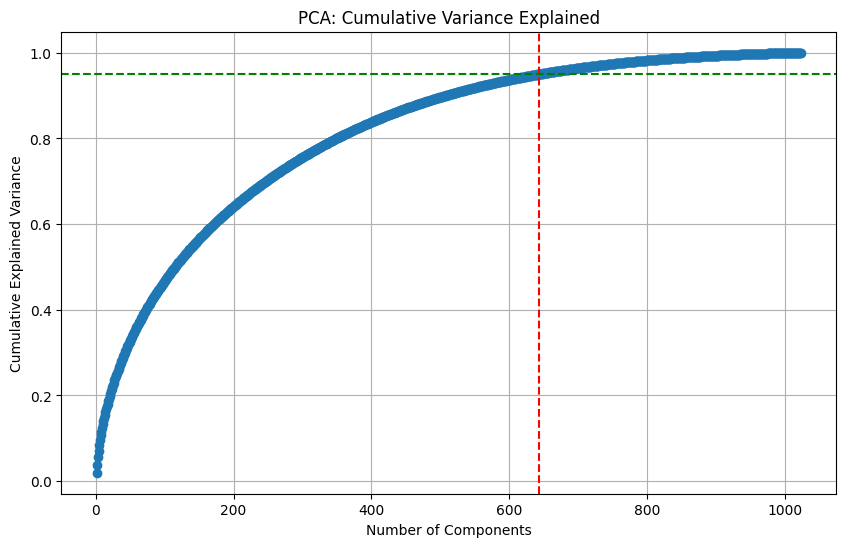


Первые 5 строк итогового DataFrame:
   BindingDB Reactant_set_id  \
0                   50722663   
1                   50849570   
2                   50573690   
3                   50833950   
4                   50447653   

                                       Ligand SMILES  \
0  COc1cnc(N2CCOCC2)c2sc(NC(=O)C(C)(C)Oc3cccc(F)c...   
1              Nc1nc2ccc(Cl)cc2n2n1nc(-c1ccccc1)c2=O   
2  CN(C)CCN(C)c1ccc2C(=O)c3c(nc(N)nc3-c3ccccc3)-c2c1   
3            Cn1c(nc2c(N)nc(CCc3ccccc3)nc12)-n1nccn1   
4      COC[C@H]1CCCN1c1cc(NC(C)=O)nc(n1)-n1nc(C)cc1C   

                                        Ligand InChI  \
0  InChI=1S/C21H23FN4O4S/c1-21(2,30-14-6-4-5-13(2...   
1  InChI=1S/C15H10ClN5O/c16-10-6-7-11-12(8-10)20-...   
2  InChI=1S/C22H23N5O/c1-26(2)11-12-27(3)15-9-10-...   
3  InChI=1S/C16H16N8/c1-23-15-13(22-16(23)24-18-9...   
4  InChI=1S/C17H24N6O2/c1-11-8-12(2)23(21-11)17-1...   

              Ligand InChI Key  BindingDB MonomerID  \
0  XSDASQOPCIPRKT-UHFFFAOYSA-N           

In [20]:


print("Стандартизация данных...")
scaler = StandardScaler()
fp_scaled = scaler.fit_transform(fp_df)

print("Применение PCA...")
pca = PCA(n_components=None)
pca.fit(fp_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"\nОптимальное число компонент: {n_components} (объясняют {cumulative_variance[n_components-1]:.2%} дисперсии)")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.axvline(n_components, color='r', linestyle='--')
plt.axhline(0.95, color='g', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Variance Explained')
plt.grid()
plt.show()

pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(fp_scaled)

pca_columns = [f'PC_{i+1}' for i in range(n_components)]
pca_df = pd.DataFrame(principal_components, columns=pca_columns)

final_df = pd.concat([df.reset_index(drop=True), pca_df], axis=1)

print("\nПервые 5 строк итогового DataFrame:")
print(final_df.head())
print(f"\nИсходная размерность: {fp_df.shape[1]}")
print(f"Новая размерность: {n_components}")

In [18]:
df

,BindingDB Reactant_set_id,Ligand SMILES,Ligand InChI,Ligand InChI Key,BindingDB MonomerID,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,IC50 (nM),Kd (nM),...,UniProt (SwissProt) Entry Name of Target Chain,UniProt (SwissProt) Primary ID of Target Chain,UniProt (SwissProt) Secondary ID(s) of Target Chain,UniProt (SwissProt) Alternative ID(s) of Target Chain,UniProt (TrEMBL) Submitted Name of Target Chain,UniProt (TrEMBL) Entry Name of Target Chain,UniProt (TrEMBL) Primary ID of Target Chain,UniProt (TrEMBL) Secondary ID(s) of Target Chain,UniProt (TrEMBL) Alternative ID(s) of Target Chain,pKi
0,50722663,COc1cnc(N2CCOCC2)c2sc(NC(=O)C(C)(C)Oc3cccc(F)c...,"InChI=1S/C21H23FN4O4S/c1-21(2,30-14-6-4-5-13(2...",XSDASQOPCIPRKT-UHFFFAOYSA-N,50235049,CHEMBL4097118,Adenosine receptor A2a,Homo sapiens,4.70,NaN,...,AA2AR_HUMAN,P29274,B2R7E0,NaN,NaN,NaN,NaN,NaN,NaN,8.327902
1,50849570,Nc1nc2ccc(Cl)cc2n2n1nc(-c1ccccc1)c2=O,InChI=1S/C15H10ClN5O/c16-10-6-7-11-12(8-10)20-...,LEOMMCGIZNQEEE-UHFFFAOYSA-N,50224350,"4-amino-8-chloro-2-phenyl-3,3a,5,9b-tetraaza-c...",Adenosine receptor A2a,Homo sapiens,4.70,NaN,...,AA2AR_HUMAN,P29274,B2R7E0,NaN,NaN,NaN,NaN,NaN,NaN,8.327902
2,50573690,CN(C)CCN(C)c1ccc2C(=O)c3c(nc(N)nc3-c3ccccc3)-c2c1,InChI=1S/C22H23N5O/c1-26(2)11-12-27(3)15-9-10-...,WUIPOKWUCKPSLZ-UHFFFAOYSA-N,50316891,2-amino-8-((2-(dimethylamino)ethyl)(methyl)ami...,Adenosine receptor A2a,Homo sapiens,4.70,NaN,...,AA2AR_HUMAN,P29274,B2R7E0,NaN,NaN,NaN,NaN,NaN,NaN,8.327902
3,50833950,Cn1c(nc2c(N)nc(CCc3ccccc3)nc12)-n1nccn1,InChI=1S/C16H16N8/c1-23-15-13(22-16(23)24-18-9...,ABAHFXBQXJPKNX-UHFFFAOYSA-N,50176059,"9-Methyl-2-phenethyl-8-[1,2,3]triazol-2-yl-9H-...",Adenosine receptor A2a,Homo sapiens,4.70,NaN,...,AA2AR_HUMAN,P29274,B2R7E0,NaN,NaN,NaN,NaN,NaN,NaN,8.327902
4,50447653,COC[C@H]1CCCN1c1cc(NC(C)=O)nc(n1)-n1nc(C)cc1C,InChI=1S/C17H24N6O2/c1-11-8-12(2)23(21-11)17-1...,FGADYIBOWLXZLA-CQSZACIVSA-N,50266416,"CHEMBL458224::N-[2-(3,5-Dimethylpyrazol-1-yl)-...",Adenosine receptor A2a,Homo sapiens,4.70,NaN,...,AA2AR_HUMAN,P29274,B2R7E0,NaN,NaN,NaN,NaN,NaN,NaN,8.327902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10919,50530380,Nc1nc2n(CCCc3ccc(cc3)C(O)=O)ncc2c2nc(nn12)-c1c...,InChI=1S/C20H17N7O3/c21-20-24-17-14(18-23-16(2...,UDSMQGVVBMEYMA-UHFFFAOYSA-N,50108021,"4-(3-(5-amino-2-(furan-2-yl)-7H-pyrazolo[4,3-e...",Adenosine receptor A2a,Homo sapiens,4.63,NaN,...,AA2AR_HUMAN,P29274,B2R7E0,NaN,NaN,NaN,NaN,NaN,NaN,8.334419
10920,50195496,Nc1nc2n(CCCc3ccc(cc3)C(O)=O)ncc2c2nc(nn12)-c1c...,InChI=1S/C20H17N7O3/c21-20-24-17-14(18-23-16(2...,UDSMQGVVBMEYMA-UHFFFAOYSA-N,50108021,"4-(3-(5-amino-2-(furan-2-yl)-7H-pyrazolo[4,3-e...",Adenosine receptor A2a,Homo sapiens,4.63,NaN,...,AA2AR_HUMAN,P29274,B2R7E0,NaN,NaN,NaN,NaN,NaN,NaN,8.334419
10921,50962304,COc1ccccc1CNc1nc(N)c2nc(sc2n1)-c1ccccc1,InChI=1S/C19H17N5OS/c1-25-14-10-6-5-9-13(14)11...,REDHRMQBZHBARB-UHFFFAOYSA-N,50275599,CHEMBL4127213,Adenosine receptor A2a,Homo sapiens,4.70,NaN,...,AA2AR_HUMAN,P29274,B2R7E0,NaN,NaN,NaN,NaN,NaN,NaN,8.327902
10922,51192785,Nc1nc(nc2sc(Cc3ccccc3)cc12)-c1ncco1,InChI=1S/C16H12N4OS/c17-13-12-9-11(8-10-4-2-1-...,WBPDJKYORJQJOS-UHFFFAOYSA-N,50491100,CHEMBL2377228,Adenosine receptor A2a,Homo sapiens,4.70,NaN,...,AA2AR_HUMAN,P29274,B2R7E0,NaN,NaN,NaN,NaN,NaN,NaN,8.327902


In [19]:

X = fp_df.filter(regex='fp_')

y = df['pKi']

random.seed = 42
scoring = {'R2': 'r2', 'MAE': 'neg_mean_absolute_error', 'MAPE': make_scorer(mean_absolute_percentage_error, greater_is_better=False)}

In [20]:
X

,fp_0,fp_1,fp_2,fp_3,fp_4,fp_5,fp_6,fp_7,fp_8,fp_9,...,fp_1014,fp_1015,fp_1016,fp_1017,fp_1018,fp_1019,fp_1020,fp_1021,fp_1022,fp_1023
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10919,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10920,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10921,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10922,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state= 42, test_size= 0.2)
print("Количество NaN в y_train:", y_train.isna().sum())

Количество NaN в y_train: 0


In [22]:
mask = y_train.notna()
X_train_clean = X_train[mask]
y_train_clean = y_train[mask]

In [23]:
LineModel = LinearRegression()
Lineresults = cross_validate(LineModel, X_train_clean, y_train_clean, cv=5, scoring=scoring)

print("Средний R²:", Lineresults['test_R2'].mean())
print("Средний MAE:", -Lineresults['test_MAE'].mean())
print("Средний MAPE:", -Lineresults['test_MAPE'].mean())






Средний R²: 0.6205441633961064
Средний MAE: 0.6270798443676671
Средний MAPE: 0.5788690746641503


In [ ]:
ForestModel = RandomForestRegressor()
Forestresults = cross_validate(ForestModel, X_train, y_train, cv=2, scoring=scoring)

print("Средний R²:", Forestresults['test_R2'].mean())
print("Средний MAE:", -Forestresults['test_MAE'].mean())
print("Средний MAPE:", -Forestresults['test_MAPE'].mean())

Средний R²: 0.6295377439938953
Средний MAE: 0.6074895468791892
Средний MAPE: 0.5831547954523189


In [ ]:
BoostModel = XGBRegressor()

Boostresults = cross_validate(BoostModel, X_train_clean, y_train_clean, cv=3, scoring=scoring)

print("Средний R2:", Boostresults['test_R2'].mean())
print("Средний MAE:", -Boostresults['test_MAE'].mean())
print("Средний MAPE:", -Boostresults['test_MAPE'].mean())

Средний R2: 0.6360608372335117
Средний MAE: 0.5870136671908893
Средний MAPE: 0.5682071348976517


In [ ]:
lightModel = LGBMRegressor()
lightresults = cross_validate(lightModel, X_train_clean, y_train_clean, cv=3, scoring=scoring)

print("Средний R2:", lightresults['test_R2'].mean())
print("Средний MAE:", -lightresults['test_MAE'].mean())
print("Средний MAPE:", -lightresults['test_MAPE'].mean())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 164220
[LightGBM] [Info] Number of data points in the train set: 5826, number of used features: 644
[LightGBM] [Info] Start training from score 7.022891
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 164220
[LightGBM] [Info] Number of data points in the train set: 5826, number of used features: 644
[LightGBM] [Info] Start training from score 7.039895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 164220
[LightGBM] [Info] Number of data points in the train set: 5826, number of used features: 644
[LightGBM] [Info] Sta

In [ ]:
neighborsModel = KNeighborsRegressor()
neighresults = cross_validate(neighborsModel, X_train_clean, y_train_clean, cv=5, scoring=scoring)

print("Средний R2:", neighresults['test_R2'].mean())
print("Средний MAE:", -neighresults['test_MAE'].mean())
print("Средний MAPE:", -neighresults['test_MAPE'].mean())

Средний R2: 0.6660412532393549
Средний MAE: 0.5464086521471185
Средний MAPE: 0.5861988861759658


In [ ]:
ridge_model = Ridge(alpha=1.0)
Ridgeresults = cross_validate(ridge_model, X_train, y_train, cv=5, scoring=scoring)

print("Средний R2:", Ridgeresults['test_R2'].mean())
print("Средний MAE:", -Ridgeresults['test_MAE'].mean())
print("Средний MAPE:", -Ridgeresults['test_MAPE'].mean())

Средний R2: 0.6066630389713478
Средний MAE: 0.6450401814577612
Средний MAPE: 0.5706418384342995


In [ ]:
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train,y_train)
lassoresults = cross_validate(lasso_model, X_train_clean, y_train_clean, cv=5, scoring=scoring)
print("Средний R2:", lassoresults['test_R2'].mean())
print("Средний MAE:", -lassoresults['test_MAE'].mean())
print("Средний MAPE:", -lassoresults['test_MAPE'].mean())

Средний R2: 0.4499496342124404
Средний MAE: 0.7845043063887827
Средний MAPE: 0.5667123937694589


In [25]:
y_train_clean,

(4696    6.049149
 7307    4.630784
 6041    8.259637
 157     8.221849
 6973    5.000000
           ...   
 5734    5.638272
 5191    5.980884
 5390    5.863279
 860     8.000000
 7270    8.075721
 Name: pKi, Length: 8739, dtype: float64,)

In [ ]:
CatModel = CatBoostRegressor()
Catsresults = cross_validate(CatModel, X_train_clean, y_train_clean, cv=4, scoring=scoring)

print("Средний R2:", Catsresults['test_R2'].mean())
print("Средний MAE:", -Catsresults['test_MAE'].mean())
print("Средний MAPE:", -Catsresults['test_MAPE'].mean())

Learning rate set to 0.055105
0:	learn: 1.3413779	total: 325ms	remaining: 5m 24s
1:	learn: 1.3191909	total: 541ms	remaining: 4m 30s
2:	learn: 1.2976490	total: 781ms	remaining: 4m 19s
3:	learn: 1.2757584	total: 994ms	remaining: 4m 7s
4:	learn: 1.2590592	total: 1.22s	remaining: 4m 1s
5:	learn: 1.2415907	total: 1.44s	remaining: 3m 57s
6:	learn: 1.2226136	total: 1.64s	remaining: 3m 53s
7:	learn: 1.2065492	total: 1.89s	remaining: 3m 54s
8:	learn: 1.1903205	total: 2.12s	remaining: 3m 53s
9:	learn: 1.1764519	total: 2.34s	remaining: 3m 52s
10:	learn: 1.1612084	total: 2.56s	remaining: 3m 49s
11:	learn: 1.1488515	total: 2.79s	remaining: 3m 50s
12:	learn: 1.1363408	total: 3.02s	remaining: 3m 49s
13:	learn: 1.1255632	total: 3.24s	remaining: 3m 48s
14:	learn: 1.1140139	total: 3.45s	remaining: 3m 46s
15:	learn: 1.1049956	total: 3.66s	remaining: 3m 45s
16:	learn: 1.0958644	total: 3.89s	remaining: 3m 45s
17:	learn: 1.0875502	total: 4.12s	remaining: 3m 44s
18:	learn: 1.0776644	total: 4.34s	remaining: 3

In [26]:
CatBoost = CatBoostRegressor().fit(X_train_clean, y_train_clean)
Catresults = CatBoost.predict(X_test)
print(r2_score(y_test,Catresults))

Learning rate set to 0.057667
0:	learn: 1.3326041	total: 161ms	remaining: 2m 41s
1:	learn: 1.3039120	total: 303ms	remaining: 2m 31s
2:	learn: 1.2775864	total: 457ms	remaining: 2m 31s
3:	learn: 1.2541087	total: 557ms	remaining: 2m 18s
4:	learn: 1.2349071	total: 638ms	remaining: 2m 7s
5:	learn: 1.2182551	total: 722ms	remaining: 1m 59s
6:	learn: 1.1982681	total: 828ms	remaining: 1m 57s
7:	learn: 1.1811193	total: 899ms	remaining: 1m 51s
8:	learn: 1.1647100	total: 1s	remaining: 1m 50s
9:	learn: 1.1501278	total: 1.06s	remaining: 1m 45s
10:	learn: 1.1371777	total: 1.13s	remaining: 1m 41s
11:	learn: 1.1255468	total: 1.23s	remaining: 1m 41s
12:	learn: 1.1116682	total: 1.29s	remaining: 1m 38s
13:	learn: 1.1015616	total: 1.39s	remaining: 1m 37s
14:	learn: 1.0915162	total: 1.47s	remaining: 1m 36s
15:	learn: 1.0835772	total: 1.55s	remaining: 1m 35s
16:	learn: 1.0737213	total: 1.64s	remaining: 1m 34s
17:	learn: 1.0649387	total: 1.72s	remaining: 1m 33s
18:	learn: 1.0568085	total: 1.81s	remaining: 1m 

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve

print(f"mean_absolute_error: {mean_absolute_error(y_test, Catresults)}")
print(f"r2_score: {r2_score(y_test, Catresults)}")

mean_absolute_error: 0.48174821502266374
r2_score: 0.7598653753301077


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 10.4 MB/s eta 0:00:00


In [29]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display


In [30]:
hash_ligands = pd.read_csv('hash_ligand_mapping.csv', header=None)
hash_ligands = hash_ligands.rename(columns={0:'file ligand', 1: 'SMILES'})
hash_ligands

,file ligand,SMILES
0,cbfd0789e4e77ddf7d2bd5d50abd54e01df540e6,Nc1nc2n(CCN3CCN(CC3)c3cccc(Cl)c3)ncc2c2nc(nn12...
1,9d37ae43447147b961a2b36b30bc48d967bb3d7f,Cc1cccc(c1)-c1c(nc(N)n2nc(Cc3ncccc3F)nc12)-c1c...
2,ca731c4dfd013f77389ae54791f559abe7346741,Cn1c2nc([nH]c2c(=O)n(C)c1=O)-c1ccc(OCC(=O)NCc2...
3,418e8cb4c27878dfcfc510e2c8c90ac904df64c9,CC(C)n1cc(ccc1=O)-c1c(nc(N)n2nc(Cc3ncccc3F)nc1...
4,5d55d6c9c4b7db3624ae9d1f5d76f9b1ebb870ec,COc1cc(OCC(=O)Nc2ccc(cc2)-c2cc3n(C)c(=O)n(C)c(...
5,97af5201983114dbd40f350e7ef5607322785896,Cn1c(nc2c(NC3CCCC3)ncnc12)-c1ccccc1
6,7858869a8fac52cd79b0be940edd4a322478c063,O[C@@H]1[C@@H]2C[C@@H]2[C@H]([C@@H]1O)n1cnc2c(...
7,b1bc750a820137c6bda4408b00e29ea28104d32d,CCCn1c2nc([nH]c2c(=O)n(CCC)c1=O)-c1cnn(Cc2nc(n...
8,23710cf11f845f32f31b0cee956266aba8866c25,COc1cc(ccc1OCC(=O)Nc1ccc(F)cc1)-c1cc2n(C)c(=O)...
9,00514a76312bc2a94adef01fdccef3c73ab25838,Nc1nc(nc2sc(Cc3ccccc3)cc12)-c1ccccc1


In [31]:
from rdkit.Chem import Descriptors
valid_ligands = []
for smiles in hash_ligands['SMILES']:
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        print('invalid')
    else:
        ligand = Descriptors.CalcMolDescriptors(m)
        valid_ligands.append(smiles)
valid_ligands = pd.DataFrame(valid_ligands, columns=['SMILES'])
valid_ligands

,SMILES
0,Nc1nc2n(CCN3CCN(CC3)c3cccc(Cl)c3)ncc2c2nc(nn12...
1,Cc1cccc(c1)-c1c(nc(N)n2nc(Cc3ncccc3F)nc12)-c1c...
2,Cn1c2nc([nH]c2c(=O)n(C)c1=O)-c1ccc(OCC(=O)NCc2...
3,CC(C)n1cc(ccc1=O)-c1c(nc(N)n2nc(Cc3ncccc3F)nc1...
4,COc1cc(OCC(=O)Nc2ccc(cc2)-c2cc3n(C)c(=O)n(C)c(...
5,Cn1c(nc2c(NC3CCCC3)ncnc12)-c1ccccc1
6,O[C@@H]1[C@@H]2C[C@@H]2[C@H]([C@@H]1O)n1cnc2c(...
7,CCCn1c2nc([nH]c2c(=O)n(CCC)c1=O)-c1cnn(Cc2nc(n...
8,COc1cc(ccc1OCC(=O)Nc1ccc(F)cc1)-c1cc2n(C)c(=O)...
9,Nc1nc(nc2sc(Cc3ccccc3)cc12)-c1ccccc1


In [32]:
from rdkit import Chem
from rdkit.Chem import QED
qed_properties = []
for value in valid_ligands['SMILES']:
    x = Chem.MolFromSmiles(value)
    res = QED.qed(x)
    qed_properties.append(res)
qed_properties

[0.4237609551329474,
 0.45197987065932427,
 0.48976298751318303,
 0.4131103397327411,
 0.4334668456029606,
 0.8039853218924633,
 0.5290778046893279,
 0.3499193491049362,
 0.4672532129339853,
 0.6036927555831172,
 0.40225946183347255,
 0.5817660039891922,
 0.7298535042642875,
 0.6007272431028231,
 0.6570342667633778,
 0.47176382828594127,
 0.7965479280080782,
 0.38139010162666165,
 0.5999341559055507,
 0.5943538598489927,
 0.4924018007970553,
 0.48769519146236395,
 0.43941548342436704,
 0.5655544943795058,
 0.7448580888638292,
 0.6021535503236989,
 0.4043270960902814,
 0.4906723536125982,
 0.6060496673681548,
 0.7501313063067567,
 0.18891690285981616,
 0.3181506759488066,
 0.6071455625131529,
 0.37760986089870224,
 0.43888747532762873,
 0.7912371560734027,
 0.34952939970062213,
 0.7982013162212954,
 0.2559328804247914,
 0.43082927363494367,
 0.4804697071988441,
 0.40438568403882813,
 0.4712299562936254,
 0.5043573712072165,
 0.7653430477176343,
 0.37889430030196264,
 0.49501203735232774

In [33]:
from rdkit.Contrib.SA_Score import sascorer
SA_score = []
for value in valid_ligands['SMILES']:
    x = Chem.MolFromSmiles(value)
    res = sascorer.calculateScore(x)
    SA_score.append(res)
SA_score

[2.739208214311679,
 2.70985789624209,
 2.2408037036023973,
 3.0207825942578594,
 2.467626274609252,
 2.2415903394352767,
 3.9785437770545355,
 2.831544678173943,
 2.390713787873036,
 2.0528327593991733,
 2.6232388427219764,
 2.428034412540585,
 1.8962552636894365,
 2.539027717864764,
 2.4258855711997303,
 2.71876156589469,
 1.9486670457011055,
 2.6797582935585584,
 2.5072363295970934,
 2.7184710494944486,
 2.7016836092930827,
 2.3169713959100893,
 2.813729169346093,
 2.6273922340273703,
 2.554222664748071,
 2.202638510057646,
 2.9882873992400096,
 2.605777381154482,
 2.3373026775041286,
 1.9617621787551904,
 3.7779215875902015,
 4.186859746800369,
 2.571156346453405,
 2.873901450256419,
 2.9719536476894444,
 2.0242420800081184,
 3.9830078848957546,
 1.7771454725713731,
 3.860931198949105,
 2.734247592042964,
 2.1849810336024955,
 2.827574555694481,
 2.78133140503771,
 2.5542326976852383,
 2.3606741226713375,
 2.4176864770384014,
 2.8791608279647267,
 2.052091756219978,
 2.460159807605

In [34]:
valid_ligands_properties = pd.concat([valid_ligands, pd.Series(qed_properties), pd.Series(SA_score)], axis=1)

In [35]:
valid_ligands_properties = valid_ligands_properties.rename(columns={0:'QED', 1: 'SA_score'})


In [36]:
from rdkit.Chem import FilterCatalog
params = FilterCatalog.FilterCatalogParams()
params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog.FilterCatalog(params)
PAINS = []
for smiles in valid_ligands_properties['SMILES']:
    pains = []
    mol = Chem.MolFromSmiles(smiles)  # nitrobenzene example
    entries = catalog.GetMatches(mol)
    for entry in entries:
        pains.append(entry.GetDescription())
    PAINS.append(pains)

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.


In [37]:
params = FilterCatalog.FilterCatalogParams()
params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.BRENK)
catalog = FilterCatalog.FilterCatalog(params)
BRENK = []
for smiles in valid_ligands_properties['SMILES']:
    brenk = []
    mol = Chem.MolFromSmiles(smiles)  # nitrobenzene example
    entries = catalog.GetMatches(mol)
    for entry in entries:
        brenk.append(entry.GetDescription())
    #if brenk:

    BRENK.append(brenk)

In [38]:
def check_lipinski(mol):
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    h_donors = Descriptors.NumHDonors(mol)
    h_acceptors = Descriptors.NumHAcceptors(mol)
    tpsa = Descriptors.TPSA(mol) #Topological Polar Surface Area

    lipinski = {
        'MolecularWeight': mw,
        'tpsa': tpsa < 90,
        'LogP': logp,
        'HDonors': h_donors,
        'HAcceptors': h_acceptors,
        'MW <= 500': mw <= 500,
        'LogP <= 5': logp <= 5,
        'HDonors <= 5': h_donors <= 5,
        'HAcceptors <= 10': h_acceptors <= 10,
        'valid': True
    }

    return lipinski

In [39]:
lipinsi_scores_all = []

for smiles in valid_ligands_properties['SMILES']:
    mol = Chem.MolFromSmiles(smiles)  # nitrobenzene example
    lipinsi_scores = check_lipinski(mol)
    lipinsi_scores_all.append(lipinsi_scores)
lipinsi_scores_all

[{'MolecularWeight': 463.93300000000016,
  'tpsa': False,
  'LogP': 2.791800000000001,
  'HDonors': 1,
  'HAcceptors': 10,
  'MW <= 500': True,
  'LogP <= 5': True,
  'HDonors <= 5': True,
  'HAcceptors <= 10': True,
  'valid': True},
 {'MolecularWeight': 428.4460000000001,
  'tpsa': True,
  'LogP': 4.6129200000000035,
  'HDonors': 1,
  'HAcceptors': 6,
  'MW <= 500': True,
  'LogP <= 5': True,
  'HDonors <= 5': True,
  'HAcceptors <= 10': True,
  'valid': True},
 {'MolecularWeight': 419.44100000000014,
  'tpsa': False,
  'LogP': 1.3224999999999996,
  'HDonors': 2,
  'HAcceptors': 7,
  'MW <= 500': True,
  'LogP <= 5': True,
  'HDonors <= 5': True,
  'HAcceptors <= 10': True,
  'valid': True},
 {'MolecularWeight': 473.48700000000014,
  'tpsa': False,
  'LogP': 4.047100000000002,
  'HDonors': 1,
  'HAcceptors': 8,
  'MW <= 500': True,
  'LogP <= 5': True,
  'HDonors <= 5': True,
  'HAcceptors <= 10': True,
  'valid': True},
 {'MolecularWeight': 464.47800000000024,
  'tpsa': False,
  'Lo

In [40]:
valid_ligands_properties_next = pd.concat([valid_ligands_properties, pd.Series(PAINS), pd.Series(BRENK), pd.DataFrame(lipinsi_scores_all)], axis=1)
valid_ligands_properties_next

,SMILES,QED,SA_score,0,1,MolecularWeight,tpsa,LogP,HDonors,HAcceptors,MW <= 500,LogP <= 5,HDonors <= 5,HAcceptors <= 10,valid
0,Nc1nc2n(CCN3CCN(CC3)c3cccc(Cl)c3)ncc2c2nc(nn12...,0.423761,2.739208,[],[],463.933,False,2.79180,1,10,True,True,True,True,True
1,Cc1cccc(c1)-c1c(nc(N)n2nc(Cc3ncccc3F)nc12)-c1c...,0.451980,2.709858,[],[],428.446,True,4.61292,1,6,True,True,True,True,True
2,Cn1c2nc([nH]c2c(=O)n(C)c1=O)-c1ccc(OCC(=O)NCc2...,0.489763,2.240804,[],[],419.441,False,1.32250,2,7,True,True,True,True,True
3,CC(C)n1cc(ccc1=O)-c1c(nc(N)n2nc(Cc3ncccc3F)nc1...,0.413110,3.020783,[],[],473.487,False,4.04710,1,8,True,True,True,True,True
4,COc1cc(OCC(=O)Nc2ccc(cc2)-c2cc3n(C)c(=O)n(C)c(...,0.433467,2.467626,[],[],464.478,False,2.26700,2,8,True,True,True,True,True
5,Cn1c(nc2c(NC3CCCC3)ncnc12)-c1ccccc1,0.803985,2.241590,[],[],293.374,True,3.38480,1,5,True,True,True,True,True
6,O[C@@H]1[C@@H]2C[C@@H]2[C@H]([C@@H]1O)n1cnc2c(...,0.529078,3.978544,[],[],450.724,False,2.76690,3,7,True,True,True,True,True
7,CCCn1c2nc([nH]c2c(=O)n(CCC)c1=O)-c1cnn(Cc2nc(n...,0.349919,2.831545,[],[],494.943,False,3.32150,1,10,True,True,True,True,True
8,COc1cc(ccc1OCC(=O)Nc1ccc(F)cc1)-c1cc2n(C)c(=O)...,0.467253,2.390714,[],[],452.442,False,2.39750,2,7,True,True,True,True,True
9,Nc1nc(nc2sc(Cc3ccccc3)cc12)-c1ccccc1,0.603693,2.052833,[],[],317.417,True,4.53130,1,4,True,True,True,True,True


In [41]:
valid_ligands_properties_next = valid_ligands_properties_next.rename(columns={0:'PAINS', 1:'BRENK'})

In [42]:
mask = (valid_ligands_properties_next['QED'] > 0.7) & (valid_ligands_properties_next['PAINS'].apply(lambda x: len(x) == 0)) & (valid_ligands_properties_next['BRENK'].apply(lambda x: len(x) == 0)) & (valid_ligands_properties_next['valid'] == True) & ((valid_ligands_properties_next['SA_score'] > 2) | (valid_ligands_properties_next['SA_score'] < 6)) & (valid_ligands_properties_next['tpsa'] == True)
selected_hits = valid_ligands_properties_next.loc[mask, :]

In [43]:
selected_hits

,SMILES,QED,SA_score,PAINS,BRENK,MolecularWeight,tpsa,LogP,HDonors,HAcceptors,MW <= 500,LogP <= 5,HDonors <= 5,HAcceptors <= 10,valid
5,Cn1c(nc2c(NC3CCCC3)ncnc12)-c1ccccc1,0.803985,2.241590,[],[],293.374,True,3.38480,1,5,True,True,True,True,True
12,O=C(Nc1cc(nc(n1)-c1ccccc1)-c1ccccc1)C1CCCC1,0.729854,1.896255,[],[],343.430,True,4.93930,1,3,True,True,True,True,True
16,COc1cccc(c1)-c1cc(nc(N)c1C#N)-c1ccccc1,0.796548,1.948667,[],[],301.349,True,3.87808,1,4,True,True,True,True,True
29,CC(C)(C)C(=O)Nc1cc(nc(n1)-c1ccccc1)-c1ccccc1,0.750131,1.961762,[],[],331.419,True,4.79520,1,3,True,True,True,True,True
35,COc1cccc(c1)-c1cc(nc(N)c1C#N)-c1ccc(F)cc1,0.791237,2.024242,[],[],319.339,True,4.01718,1,4,True,True,True,True,True
37,CC(=O)Nc1cc(nc(n1)-c1ccccc1)-c1ccccc1,0.798201,1.777145,[],[],289.338,True,3.76900,1,3,True,True,True,True,True
44,Cn1c(nc2c(NC3CCCCC3)ncnc12)-c1cccc(Cl)c1,0.765343,2.360674,[],[],341.846,True,4.42830,1,5,True,True,True,True,True
47,Cc1ccccc1CNC(=O)c1cc(nc(N)n1)-c1ccccc1Cl,0.751061,2.052092,[],[],352.825,True,3.61762,2,4,True,True,True,True,True


In [44]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from tqdm import tqdm

# Ваша функция (без изменений)
def mol_to_morgan_fp(
    smiles: str,
    radius: int = 2,
    n_bits: int = 1024,
    use_features: bool = False,
    return_none_on_error: bool = True
) -> Optional[np.ndarray]:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError("Invalid SMILES")

        fp = AllChem.GetMorganFingerprintAsBitVect(
            mol,
            radius=radius,
            nBits=n_bits,
            useFeatures=use_features
        )

        arr = np.zeros((n_bits,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr

    except Exception as e:
        if return_none_on_error:
            return None
        raise ValueError(f"Failed to generate fingerprint: {str(e)}")

# Применение к selected_hits['SMILES']
fingerprints = []
valid_indices = []

for i, smiles in enumerate(tqdm(selected_hits['SMILES'], desc="Generating fingerprints")):
    fp = mol_to_morgan_fp(smiles)
    if fp is not None:
        fingerprints.append(fp)
        valid_indices.append(i)

# Проверка валидных отпечатков
if not fingerprints:
    raise ValueError("Не удалось сгенерировать ни одного отпечатка. Проверьте SMILES в selected_hits.")

# Обновление DataFrame
selected_hits_filtered = selected_hits.iloc[valid_indices].reset_index(drop=True)
fingerprints = np.vstack(fingerprints)

# Создание DataFrame с фингерпринтами
fp_df = pd.DataFrame(fingerprints, columns=[f'fp_{i}' for i in range(fingerprints.shape[1])])

# Объединение с исходными данными
result_df = pd.concat([selected_hits_filtered, fp_df], axis=1)

# Результат
print(f"\nУспешно обработано {len(result_df)} молекул из {len(selected_hits)}")
result_X = result_df.filter(regex='fp_')
result_X

Generating fingerprints:   0%|          | 0/8 [00:00<?, ?it/s][09:51:10] DEPRECATION WARNING: please use MorganGenerator
[09:51:10] DEPRECATION WARNING: please use MorganGenerator
[09:51:10] DEPRECATION WARNING: please use MorganGenerator
[09:51:10] DEPRECATION WARNING: please use MorganGenerator
[09:51:10] DEPRECATION WARNING: please use MorganGenerator
[09:51:10] DEPRECATION WARNING: please use MorganGenerator
[09:51:10] DEPRECATION WARNING: please use MorganGenerator
[09:51:10] DEPRECATION WARNING: please use MorganGenerator
Generating fingerprints: 100%|██████████| 8/8 [00:00<00:00, 1485.17it/s]


Успешно обработано 8 молекул из 8


,fp_0,fp_1,fp_2,fp_3,fp_4,fp_5,fp_6,fp_7,fp_8,fp_9,...,fp_1014,fp_1015,fp_1016,fp_1017,fp_1018,fp_1019,fp_1020,fp_1021,fp_1022,fp_1023
0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
CatrPredict = CatBoost.predict(result_X)
CatrPredict

array([6.04041439, 6.76030177, 7.28389245, 6.55128766, 7.51304874,
       6.61539294, 6.26582619, 7.24575801])

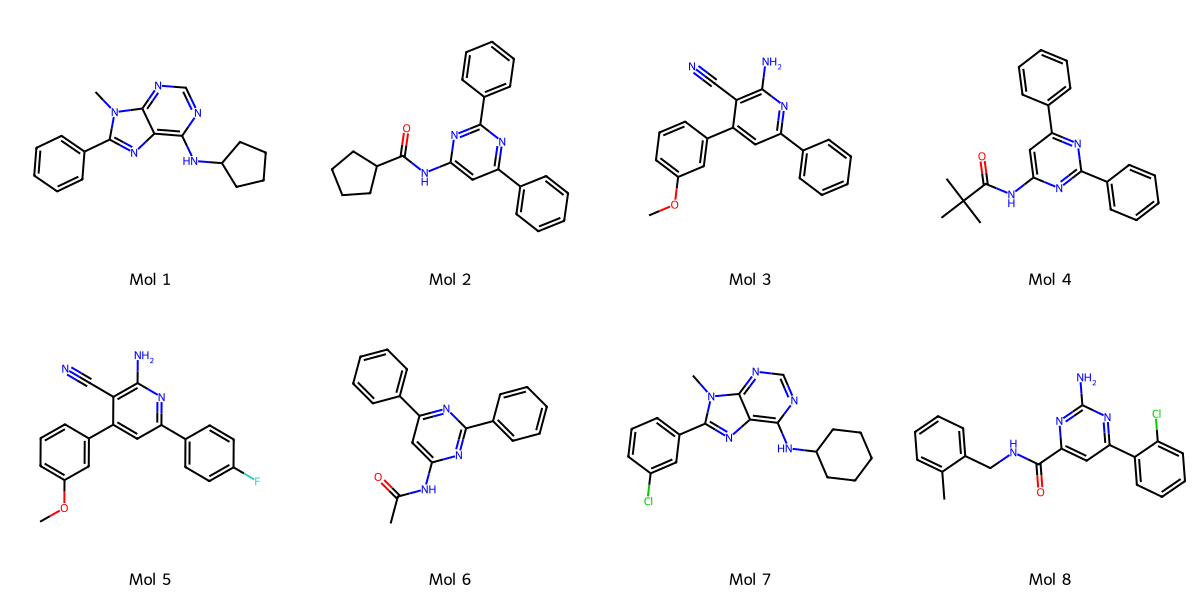

In [56]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole  # Для отображения в Jupyter

# 1. Преобразуем SMILES в молекулы
mols = [Chem.MolFromSmiles(smiles) for smiles in selected_hits['SMILES']]

# 2. Фильтруем None (невалидные SMILES)
valid_mols = [mol for mol in mols if mol is not None]

# 3. Рисуем все молекулы в сетке
img = Draw.MolsToGridImage(
    valid_mols,
    molsPerRow=4,  # 4 молекулы в ряд
    subImgSize=(300, 300),  # Размер каждого изображения
    legends=[f"Mol {i+1}" for i in range(len(valid_mols))]  # Подписи
)
display(img)